In [20]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
from skimage.color import gray2rgb

def crf(input_img, mask):
    
    # Convert mask to RBG if it's Grayscale.
    if(len(mask.shape)<3):
        mask = gray2rgb(mask)
    
    # Convert mask to numpy array
    mask = mask.astype(np.uint32)
    
    # Binarize mask
    mask = (mask>=128).astype(np.uint)*255
    
    # Convert the mask's RGB color to a single 32 bit integer for each pixel.
    annotated_label = mask[:,:,0] + (mask[:,:,1]<<8) + (mask[:,:,2]<<16)
    
    # Convert the 32bit integer color to unique labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    # Create a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    # Give no of class labels in the annotated image
    n_labels = len(set(labels.flat))
    
    print("No of labels in the mask are", n_labels)
    
    # Create CRF model
    d = dcrf.DenseCRF2D(input_img.shape[1], input_img.shape[0], n_labels)

    # Get unary potentials(neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.92, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(25, 25), srgb=(114, 114, 114), rgbim=input_img,
                           compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    # Run Inference of CRF model for 4 steps. 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP(labels) back to the corresponding colors.
    MAP = colorize[MAP,:]

    return MAP.reshape(input_img.shape)

No of labels in the mask are 2


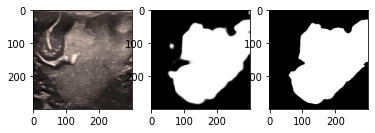

No of labels in the mask are 2


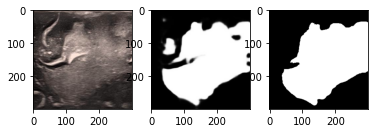

No of labels in the mask are 2


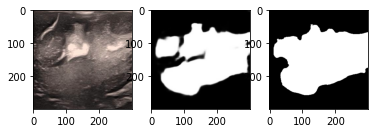

No of labels in the mask are 2


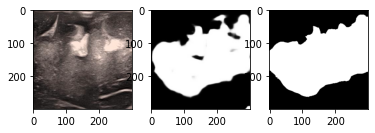

No of labels in the mask are 2


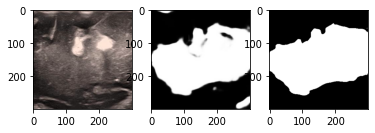

No of labels in the mask are 2


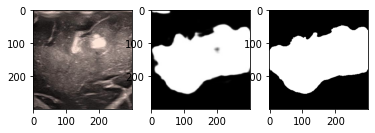

No of labels in the mask are 2


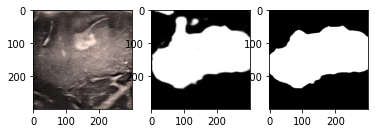

No of labels in the mask are 2


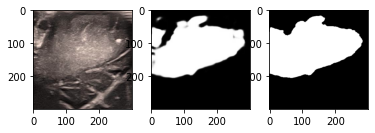

No of labels in the mask are 2


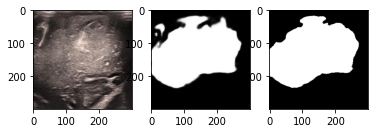

No of labels in the mask are 2


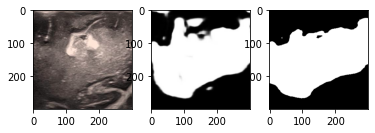

FPS is 7.152728


In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Path for original images.
imgs_path = "../datasets/testingnew/image/"
# Path for segmentation masks (can be provided by a model in this repository).
masks_path = "../CPD/results/CPD_ResNet/training2_3_9_15/24/"

files = os.listdir(imgs_path)
files.sort()

# Create save directory for enhanced images
save_path = "./crf_results/10/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

time_t = 0.0
for count, name in enumerate(files):
    input_img = cv2.imread(imgs_path+name)
    mask = cv2.imread(masks_path+name)

    # Perform crf.
    time_start = time.time()
    output_img = crf(input_img, mask)
    time_end = time.time()
    time_t = time_t + time_end - time_start

    # Show results.
    plt.subplot(1,3,1)
    plt.imshow(input_img)
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.imshow(output_img)
    plt.show()
    
    # Save output image.
    cv2.imwrite(save_path+name, output_img)

# Calculate CRF inference franerate in fps
fps = (count+1) / time_t
print('FPS is %f' %(fps))